In [1]:
import numpy as np
from itertools import product

# =========================
# 1. PARAMETERS
# =========================

beta = 0.95
r = 0.02
rent_cost = 15
mortgage_cost = 12      # make owning slightly cheaper to allow buy region
buy_cost_rate = 0.05

income_employed = 50
income_unemployed = 20

# Wealth grid
wealth_grid = np.array([0, 50, 100, 150, 200])
n_w = len(wealth_grid)

# Price states: 0=Low, 1=Med, 2=High
price_levels = np.array([100, 150, 200])
n_p = len(price_levels)

# Income states: 0=U, 1=E
n_y = 2

# =========================
# 2. TRANSITION MATRICES
# =========================

P_price = np.array([
    [0.7, 0.3, 0.0],
    [0.2, 0.6, 0.2],
    [0.0, 0.3, 0.7]
])

P_income = np.array([
    [0.6, 0.4],
    [0.1, 0.9]
])

# =========================
# 3. UTILITY
# =========================

def utility(c):
    if c <= 0:
        return -1e10
    return np.log(c)

# =========================
# 4. STATE SPACE (NO TENURE)
# =========================

states = list(product(range(n_w), range(n_p), range(n_y)))
n_states = len(states)
state_to_index = {s: i for i, s in enumerate(states)}

# =========================
# 5. VALUE FUNCTIONS
# =========================

# V = overall value
V = np.zeros(n_states)

# V_own = value if already owning (absorbing regime)
V_own = np.zeros(n_states)

policy = np.zeros(n_states)  # 0=wait, 1=buy

max_iter = 1000
tol = 1e-6

for it in range(max_iter):

    V_new = np.zeros_like(V)
    V_own_new = np.zeros_like(V_own)

    # ---- First compute V_own (no choice) ----
    for i, (w_i, p_i, y_i) in enumerate(states):

        w = wealth_grid[w_i]
        p = price_levels[p_i]
        income = income_employed if y_i == 1 else income_unemployed

        housing_cost = mortgage_cost
        c = income + r * w - housing_cost
        u = utility(c)

        EV = 0
        for p_next in range(n_p):
            for y_next in range(n_y):

                prob = P_price[p_i, p_next] * P_income[y_i, y_next]

                # capital gains while owning
                capital_gain = price_levels[p_next] - p
                w_next = w + income - housing_cost + capital_gain

                w_next = max(wealth_grid[0],
                             min(wealth_grid[-1], w_next))
                w_next_i = np.argmin(np.abs(wealth_grid - w_next))

                j = state_to_index[(w_next_i, p_next, y_next)]
                EV += prob * V_own[j]

        V_own_new[i] = u + beta * EV

    # ---- Now compute renter problem (buy or wait) ----
    for i, (w_i, p_i, y_i) in enumerate(states):

        w = wealth_grid[w_i]
        p = price_levels[p_i]
        income = income_employed if y_i == 1 else income_unemployed

        # ---- WAIT VALUE ----
        c_wait = income + r * w - rent_cost
        u_wait = utility(c_wait)

        EV_wait = 0
        for p_next in range(n_p):
            for y_next in range(n_y):

                prob = P_price[p_i, p_next] * P_income[y_i, y_next]

                w_next = w + income - rent_cost
                w_next = max(wealth_grid[0],
                             min(wealth_grid[-1], w_next))
                w_next_i = np.argmin(np.abs(wealth_grid - w_next))

                j = state_to_index[(w_next_i, p_next, y_next)]
                EV_wait += prob * V[j]

        wait_value = u_wait + beta * EV_wait

        # ---- BUY VALUE ----
        total_purchase_cost = p * (1 + buy_cost_rate)

        if w < total_purchase_cost:
            buy_value = -1e10
        else:
            w_after = w - total_purchase_cost
            w_after_i = np.argmin(np.abs(wealth_grid - w_after))
            j = state_to_index[(w_after_i, p_i, y_i)]
            buy_value = V_own[j]

        # ---- OPTIMAL DECISION ----
        if buy_value > wait_value:
            V_new[i] = buy_value
            policy[i] = 1
        else:
            V_new[i] = wait_value
            policy[i] = 0

    # Convergence check
    if max(np.max(np.abs(V_new - V)),
           np.max(np.abs(V_own_new - V_own))) < tol:
        print(f"Converged in {it} iterations")
        break

    V = V_new.copy()
    V_own = V_own_new.copy()

# =========================
# DISPLAY POLICY
# =========================

print("\nPolicy (1=Buy, 0=Wait):\n")

for s, i in state_to_index.items():
    w_i, p_i, y_i = s
    print(f"Wealth={wealth_grid[w_i]}, "
          f"PriceState={p_i}, "
          f"IncomeState={y_i} -> "
          f"Action={policy[i]}")



Converged in 295 iterations

Policy (1=Buy, 0=Wait):

Wealth=0, PriceState=0, IncomeState=0 -> Action=0.0
Wealth=0, PriceState=0, IncomeState=1 -> Action=0.0
Wealth=0, PriceState=1, IncomeState=0 -> Action=0.0
Wealth=0, PriceState=1, IncomeState=1 -> Action=0.0
Wealth=0, PriceState=2, IncomeState=0 -> Action=0.0
Wealth=0, PriceState=2, IncomeState=1 -> Action=0.0
Wealth=50, PriceState=0, IncomeState=0 -> Action=0.0
Wealth=50, PriceState=0, IncomeState=1 -> Action=0.0
Wealth=50, PriceState=1, IncomeState=0 -> Action=0.0
Wealth=50, PriceState=1, IncomeState=1 -> Action=0.0
Wealth=50, PriceState=2, IncomeState=0 -> Action=0.0
Wealth=50, PriceState=2, IncomeState=1 -> Action=0.0
Wealth=100, PriceState=0, IncomeState=0 -> Action=0.0
Wealth=100, PriceState=0, IncomeState=1 -> Action=0.0
Wealth=100, PriceState=1, IncomeState=0 -> Action=0.0
Wealth=100, PriceState=1, IncomeState=1 -> Action=0.0
Wealth=100, PriceState=2, IncomeState=0 -> Action=0.0
Wealth=100, PriceState=2, IncomeState=1 -> Act

| Wealth | PriceState=0 | PriceState=1 | PriceState=2 |
| ------ | ------------ | ------------ | ------------ |
| 0      | Wait         | Wait         | Wait         |
| 50     | Wait         | Wait         | Wait         |
| 100    | Wait         | Wait         | Wait         |
| 150    | Buy          | Wait         | Wait         |
| 200    | Buy          | Wait / Buy*  | Wait         |


(assuming you are employed)

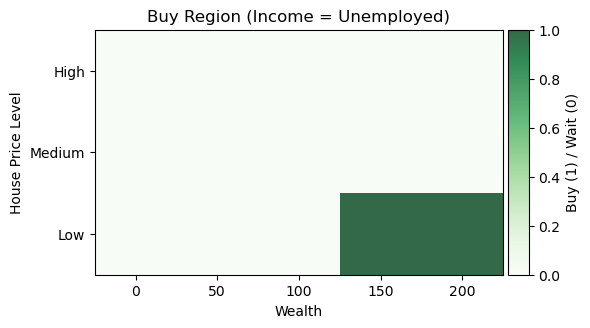

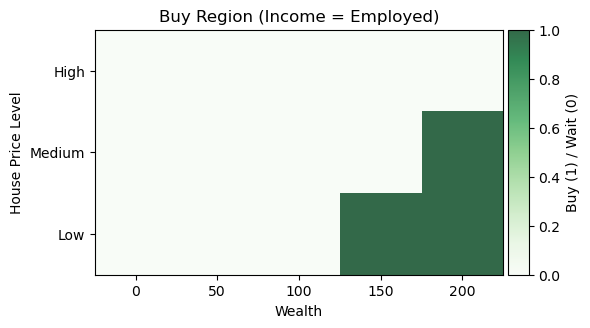

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

income_labels = ['Unemployed', 'Employed']

buy_matrix = np.zeros((n_p, n_w, 2))  # rows=price, cols=wealth, depth=income

for y_state in range(n_y):
    for w_i in range(n_w):
        for p_i in range(n_p):
            idx = state_to_index[(w_i, p_i, y_state)]
            buy_matrix[p_i, w_i, y_state] = policy[idx]


for y_state in [0, 1]:
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(buy_matrix[:, :, y_state], origin='lower', cmap='Greens', alpha=0.8)
    
    # Tick labels
    ax.set_xticks(range(n_w))
    ax.set_xticklabels(wealth_grid)
    ax.set_yticks(range(n_p))
    ax.set_yticklabels(['Low', 'Medium', 'High'])
    
    ax.set_xlabel("Wealth")
    ax.set_ylabel("House Price Level")
    ax.set_title(f"Buy Region (Income = {income_labels[y_state]})")
    
    # Create a colorbar that is **same height as the heatmap**
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # size=width, pad=space
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label("Buy (1) / Wait (0)")
    
    plt.tight_layout()
    plt.show()